# Deriving a vegetation index from PlanetScope imagery

Researchers often use a vegetation index called NDVI to measure the "greeenness" or density of vegetation across a landscape. In addition to monitoring vegetation health, NDVI (Normalized Difference Vegetation Index) can be used to track climate change, agricultural production, desertification, and land cover change. Developed by NASA scientist Compton Tucker in 1977, NDVI is derived from satellite imagery and compares reflected near-infrared light to reflected visible red light. It can be expressed as following equation:

![ndvi-equation.png](images/ndvi-equation.png)

In general, healthy and/or dense vegetation reflects a lot of near-infrared light and not as much red visible light. Conversely, when vegetation is sparse or not-so-healthy, its near-infrared reflectance decreases and its red light reflectance increases. You can read more about how NDVI is used to study cyclical, seasonal, and long-term changes to the Earth's physical characteristics from [NASA](https://earthobservatory.nasa.gov/Features/MeasuringVegetation/measuring_vegetation_1.php) and [USGS](https://phenology.cr.usgs.gov/ndvi_foundation.php) researchers. 

![tree.png](images/tree.png)

**In this guide, you'll perform a basic NDVI calculation on PlanetScope imagery using just a few lines of Python. Here are the steps:**

1. Download a PlanetScope image
2. Extract data from the red and near-infrared bands
3. Normalize the data
4. Perform the NDVI calculation
5. Save the NDVI image
6. Apply a color scheme and visualize NDVI on a map
7. Generate a histogram to view NDVI values 

### Requirements
- Python 2.7 or 3+
- [Planet's Python Client](https://www.planet.com/docs/api-quickstart-examples/cli/)
- [rasterio](https://github.com/mapbox/rasterio)
- [numpy](http://www.numpy.org/)
- [matplotlib](https://matplotlib.org/)
- [Planet API Key](https://www.planet.com/account/#/), stored as environment variable `$PL_API_KEY`.
- [Planet 4-Band Imagery](https://www.planet.com/docs/imagery-quickstart/) with the following specifications: `item-type`: `PSOrthoTile`, `REOrthoTile`, or `PSScene4Band`; `asset-type`: `analytic`, or `basic_analytic`

## Step 1. Download a PlanetScope image 

First, you're going to download a [4-band PlanetScope satellite image](https://www.planet.com/docs/spec-sheets/sat-imagery/#ps-imagery-product) of agricultural land in California's Central Valley, captured in late August 2016 (`item-id`: `20160831_180302_0e26`). You can do this using [Planet's Python client](https://www.planet.com/docs/api-quickstart-examples/cli/) to interact with our Data API, or by browsing [Planet Explorer](https://www.planet.com/products/explorer/), filtering for 4 Band PlanetScope scene (`PSScene4Band`) or Planetscope ortho tile (`PSOrthoTile`), and downloading an `analytic` asset.

Before you download the full image, you can [preview a thumbnail](https://www.planet.com/docs/reference/data-api/previews/) of the image via Planet's Data API. (The thumbnails are 256x256 by default, and can be scaled up to 512x512 by passing in a `width` parameter.) 

In [1]:
# Import the os module in order to access environment variables
import os

# If you're following along with this notebook, you can enter your API Key on the following line, and uncomment it:
#os.environ['PL_API_KEY']='8c5f983f508e4e1789da599d90c98198'

# Setup the API Key from the `PL_API_KEY` environment variable
#PLANET_API_KEY = os.getenv('PL_API_KEY')
PLANET_API_KEY = '8c5f983f508e4e1789da599d90c98198'

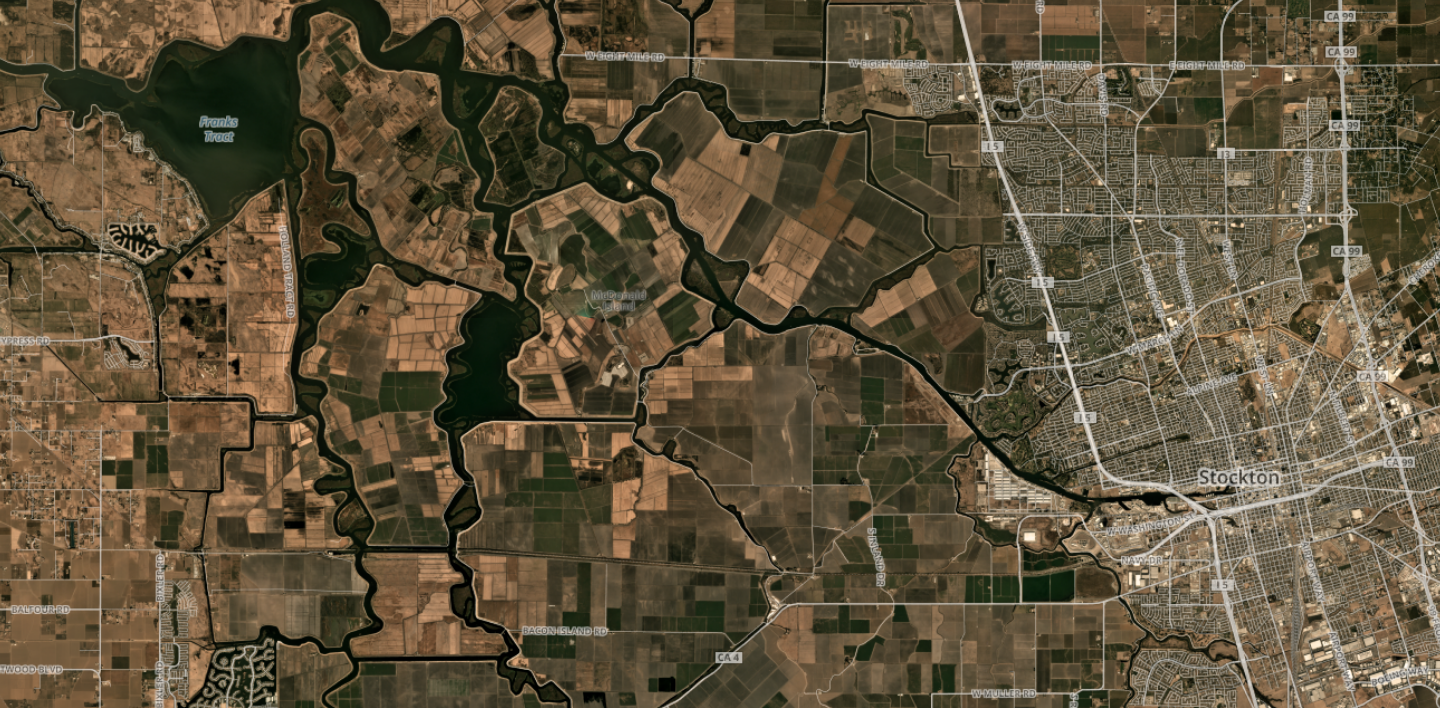

In [2]:
from IPython.display import Image
Image("images/water.png")

Next, you'll use [Planet's Python client](https://planetlabs.github.io/planet-client-python/index.html) to download the image. *Note: when you run this command, you'll get a stream of messages in your Jupyter notebook as the Python client polls the Data API to determine if the image is [activated and ready to download](https://www.planet.com/docs/api-quickstart-examples/step-2-download/#activate).*

!planet data download --item-type PSScene4Band --dest data --asset-type analytic,analytic_xml --string-in id 20160831_180302_0e26

**Congratulations!** You now have two files in your `data` directory: `20160831_180302_0e26_3B_AnalyticMS.tif` and `20160831_180302_0e26_3B_AnalyticMS_metadata.xml`. The first file is a GeoTIFF, the image you requested with spatial reference data embedded. The second file is a metadata file for that image that includes the data you'll need to calculate the NDVI. 

## Step 2. Extract the data from the red and near-infrared bands 

In this step, you'll use [Rasterio](https://github.com/mapbox/rasterio), a Python library for reading and writing geospatial raster datasets, to open the raster image you downloaded (the .tif file). Then you'll extract the data from the red and near-infrared bands and load the band data into arrays that you can manipulate using Python's [NumPy](http://www.numpy.org/) libary. *Note: in PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared.*

In [22]:
import rasterio
import numpy as np

filename = "data/download.tif"

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(filename) as src:
    band_red = src.read(3)

with rasterio.open(filename) as src:
    band_nir = src.read(4)

## Step 3. Normalize the band data

Before you can calculate NDVI, you must normalize the values in the arrays for each band using the [Top of Atmosphere (TOA) reflectance coefficients](https://landsat.usgs.gov/using-usgs-landsat-8-product) stored in metadata file you downloaded (the .xml file).

In [23]:
from xml.dom import minidom

xmldoc = minidom.parse("data/20160831_180302_0e26_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

## Step 4. Perform the NDVI calculation

Next, you're going to calculate NDVI through subtraction and division of the normalized values stored in the NumPy arrays. This calculation will give you NDVI values that range from -1 to 1. Values closer to 1 indicate a greater density of vegetation or higher level of "greenness."

In [24]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [25]:
# check range NDVI values, excluding NaN
np.nanmin(ndvi), np.nanmax(ndvi)

(0.22533246046800573, 1.0)

## Step 5. Save the NDVI image 

Next, you're going to save the calculated NDVI values to a new image file, making sure the new image file has the same geospatial metadata as the original GeoTIFF we downloaded.

In [26]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.uint8,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('output/ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.uint8))

## Step 6. Apply a color scheme to visualize the NDVI values on the image

In the last two steps, you'll use [Matplotlib](https://matplotlib.org/) to visualize the NDVI values you calculated for the PlanetScope scene. First you'll view a map of the NDVI values; then you'll generate a histogram of NDVI values. 

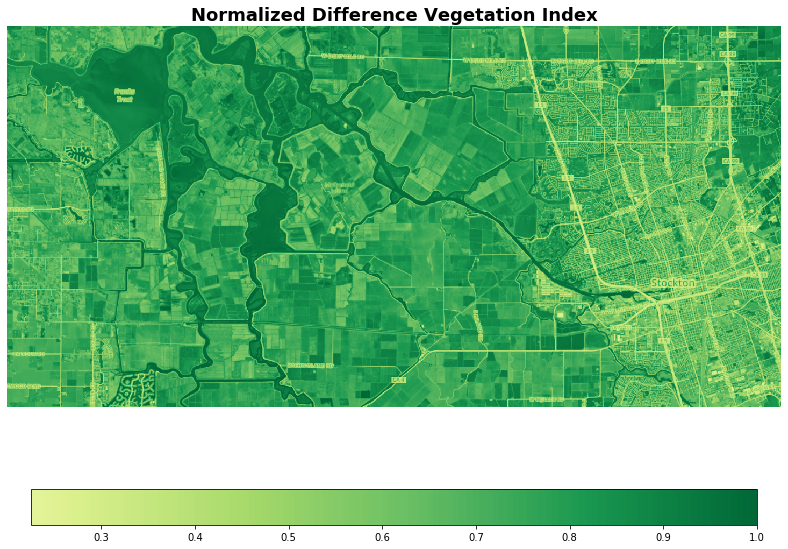

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig("output/ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

## 7. Generate a histogram of NDVI values

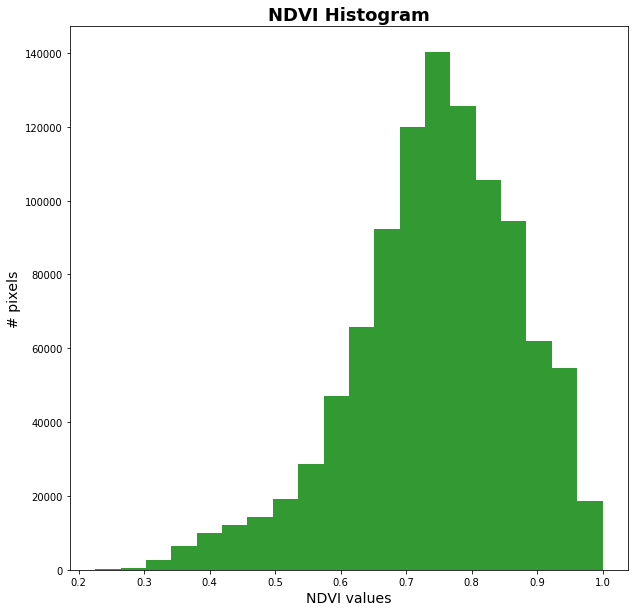

In [28]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

fig2.savefig("output/ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

![plants.png](images/plants.png)

In [21]:
ndvi.mean()

0.8051682869342128